# 1. Exploratory Data Analysis (EDA)

In [22]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import norm

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# Load the Parquet file as a lazy Polars DataFrame
lazy_df = pl.scan_parquet('../data/transactions.parquet')

num_rows = lazy_df.select(pl.len()).collect().item()
num_cols = len(lazy_df.collect_schema().names())
print('Dataframe shape:', (num_rows, num_cols))

Dataframe shape: (307532073, 23)


In [3]:
# Convert SHOP_DATE to datetime and drop unnecessary columns
lazy_df = (
    lazy_df
    .with_columns(
        pl.col("SHOP_DATE").cast(pl.Utf8).str.strptime(pl.Date, format="%Y%m%d")
    )
    .drop([
        'CUST_CODE',
        'BASKET_ID',
        'BASKET_SIZE',
        '__null_dask_index__'
    ])
)

## Dates validation

In [4]:
# Products without missing days
products_no_missing_list = (
    lazy_df
    .group_by("PROD_CODE")
    .agg([
        pl.col("SHOP_DATE").min().alias("min_date"),
        pl.col("SHOP_DATE").max().alias("max_date"),
        pl.col("SHOP_DATE").n_unique().alias("unique_dates")
    ])
    .with_columns(
        (pl.col("max_date") - pl.col("min_date")).dt.total_days().alias("expected_days")
    )
    .with_columns(
        (pl.col("expected_days") + 1 - pl.col("unique_dates")).alias("missing_days")
    )
    .filter(pl.col("missing_days") == 0)
    .select("PROD_CODE")
    .collect()
    .to_series()
    .to_list()
)

lazy_df_filtered = lazy_df.filter(pl.col("PROD_CODE").is_in(products_no_missing_list))

## Top 100 Products

In [5]:
# Create a list of the top 100 products
top_100_by_sales_list = (
    lazy_df_filtered
    .group_by("PROD_CODE")
    .agg(pl.sum("SPEND").alias("total_sales"))
    .sort("total_sales", descending=True)
    .limit(100)
    .select("PROD_CODE")
    .collect()
    .to_series()
    .to_list()
)


## Daily Aggregation

In [6]:
# Process daily data for the selected products
product_daily = (
    lazy_df_filtered
    .filter(pl.col("PROD_CODE").is_in(top_100_by_sales_list))
    .with_columns(
        (pl.col("SPEND") / pl.col("QUANTITY")).alias("PRICE")
    )
    .group_by(["SHOP_DATE", "PROD_CODE"])
    .agg([
        pl.mean("PRICE").alias("avg_price"),
        pl.sum("QUANTITY").alias("total_units"),
        pl.sum("SPEND").alias("total_sales")
    ])
    .sort(["SHOP_DATE", "PROD_CODE"])
    .collect(engine="streaming")
)

num_rows, num_cols = product_daily.shape
print('Final Dataframe shape:', (num_rows, num_cols))

Final Dataframe shape: (81711, 5)


In [7]:
# Calculate nunique prices per product for each product and return number of unique prices
nunique_prices = (
    product_daily
    .group_by("PROD_CODE")
    .agg(pl.col("avg_price").n_unique().alias("nunique_prices"))
)

nunique_prices.sort("nunique_prices", descending=True).head(100)

PROD_CODE,nunique_prices
str,u32
"""PRD0901068""",819
"""PRD0902112""",819
"""PRD0901265""",819
"""PRD0902503""",819
"""PRD0903052""",819
…,…
"""PRD0903627""",1
"""PRD0904945""",1
"""PRD0900357""",1


## Validations

In [8]:
price_outliers = (
    product_daily
    .group_by("PROD_CODE")
    .agg([
        pl.min("avg_price").alias("min_price"),
        pl.max("avg_price").alias("max_price"),
        pl.mean("avg_price").alias("avg_price")
    ])
    .with_columns((pl.col("max_price") / pl.col("avg_price")).alias("price_ratio"))
    .sort("price_ratio", descending=True)
)

price_outliers.head(10)

PROD_CODE,min_price,max_price,avg_price,price_ratio
str,f64,f64,f64,f64
"""PRD0900329""",2.355331,4.930457,2.666591,1.848974
"""PRD0902503""",5.288604,10.866492,6.996081,1.553226
"""PRD0903107""",9.205094,16.657867,12.131114,1.373152
"""PRD0900302""",0.81994,1.320181,1.037059,1.273004
"""PRD0900324""",6.051353,9.285718,7.323704,1.267899
"""PRD0900173""",1.334461,1.802244,1.444853,1.247355
"""PRD0900239""",1.268808,1.884921,1.539881,1.224069
"""PRD0900220""",4.508176,6.269882,5.209691,1.203504
"""PRD0900129""",6.318016,8.508621,7.076091,1.202446


In [9]:
product_daily.collect_schema()

Schema([('SHOP_DATE', Date),
        ('PROD_CODE', String),
        ('avg_price', Float64),
        ('total_units', Int64),
        ('total_sales', Float64)])

In [10]:
price_outliers_val = (
    product_daily
    .group_by("PROD_CODE", "SHOP_DATE")
    .agg([
        pl.min("avg_price").alias("min_price"),
        pl.max("avg_price").alias("max_price"),
        pl.mean("avg_price").alias("avg_price")
    ])
    .with_columns((pl.col("max_price") / pl.col("avg_price")).alias("price_ratio"))
    .sort("price_ratio", descending=False)
)

price_outliers_val.head(100)

PROD_CODE,SHOP_DATE,min_price,max_price,avg_price,price_ratio
str,date,f64,f64,f64,f64
"""PRD0901348""",2006-12-09,2.06,2.06,2.06,1.0
"""PRD0904358""",2006-08-30,1.54,1.54,1.54,1.0
"""PRD0904887""",2007-03-06,1.02,1.02,1.02,1.0
"""PRD0903774""",2006-06-09,2.14,2.14,2.14,1.0
"""PRD0902503""",2008-04-17,7.033135,7.033135,7.033135,1.0
…,…,…,…,…,…
"""PRD0901335""",2007-11-21,10.48284,10.48284,10.48284,1.0
"""PRD0903497""",2007-03-21,1.28,1.28,1.28,1.0
"""PRD0903763""",2006-05-19,4.215877,4.215877,4.215877,1.0


In [11]:
quantity_outliers = (
    product_daily
    .group_by("PROD_CODE")
    .agg([
        pl.min("total_units").alias("min_units"),
        pl.max("total_units").alias("max_units"),
        pl.mean("total_units").alias("avg_units")
    ])
    .with_columns((pl.col("max_units") / pl.col("avg_units")).alias("units_ratio"))
    .sort("units_ratio", descending=True)
)

quantity_outliers.head(10)

PROD_CODE,min_units,max_units,avg_units,units_ratio
str,i64,i64,f64,f64
"""PRD0903578""",6,1801,99.539683,18.093287
"""PRD0900803""",20,3554,222.084249,16.002936
"""PRD0901675""",12,935,59.180708,15.799067
"""PRD0903622""",5,1266,86.010989,14.719049
"""PRD0904942""",9,981,88.981685,11.024741
"""PRD0902066""",10,857,93.566545,9.159257
"""PRD0904014""",79,2862,329.74359,8.679471
"""PRD0901310""",8,1301,154.140415,8.440356
"""PRD0901923""",21,2324,276.604396,8.401891


## Price and Units Analysis

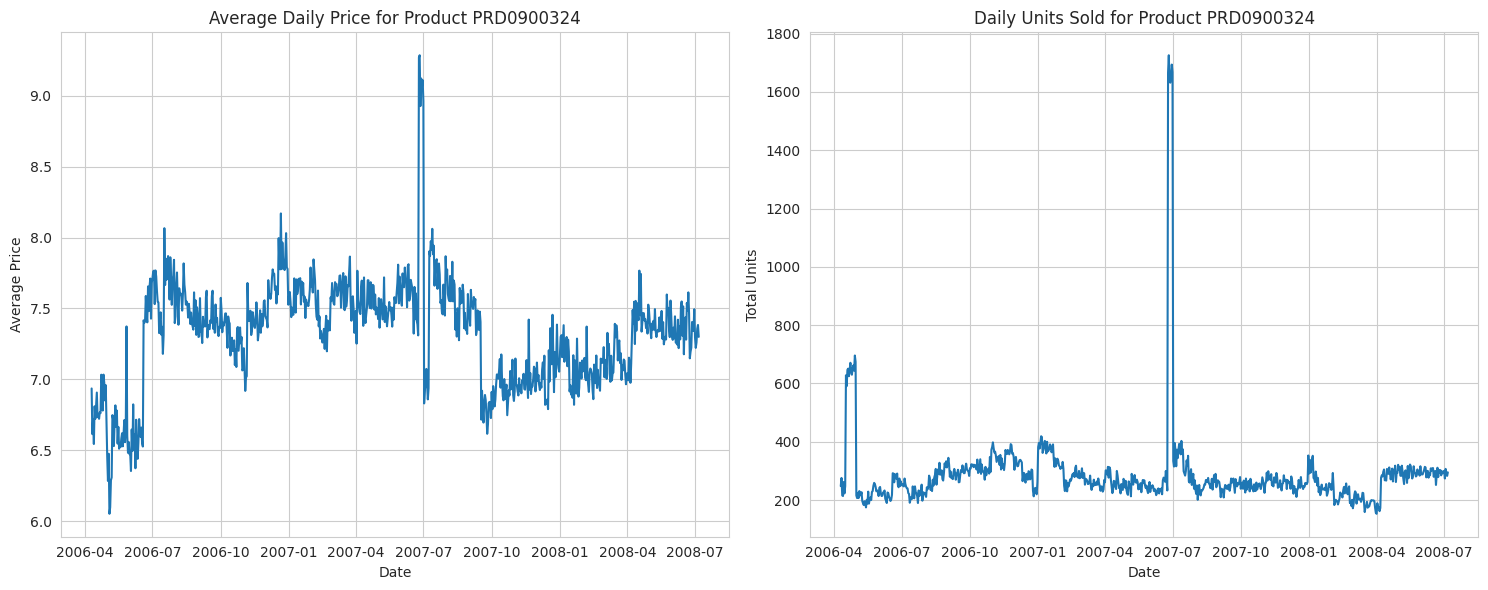

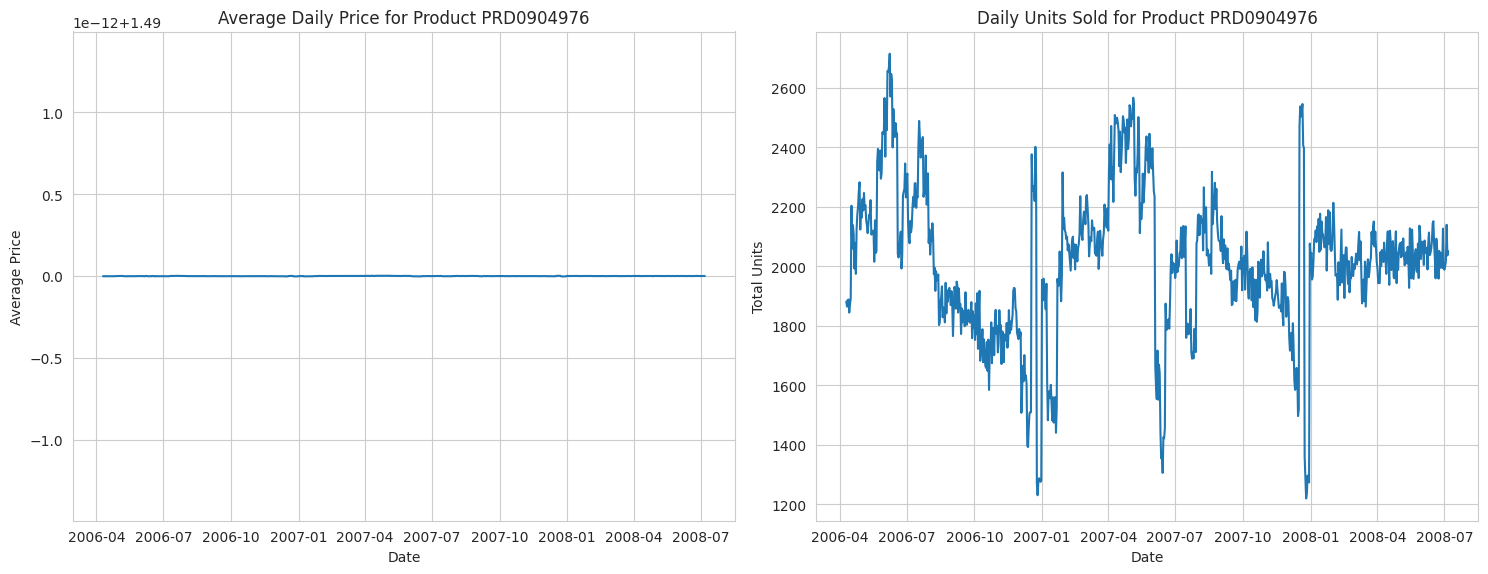

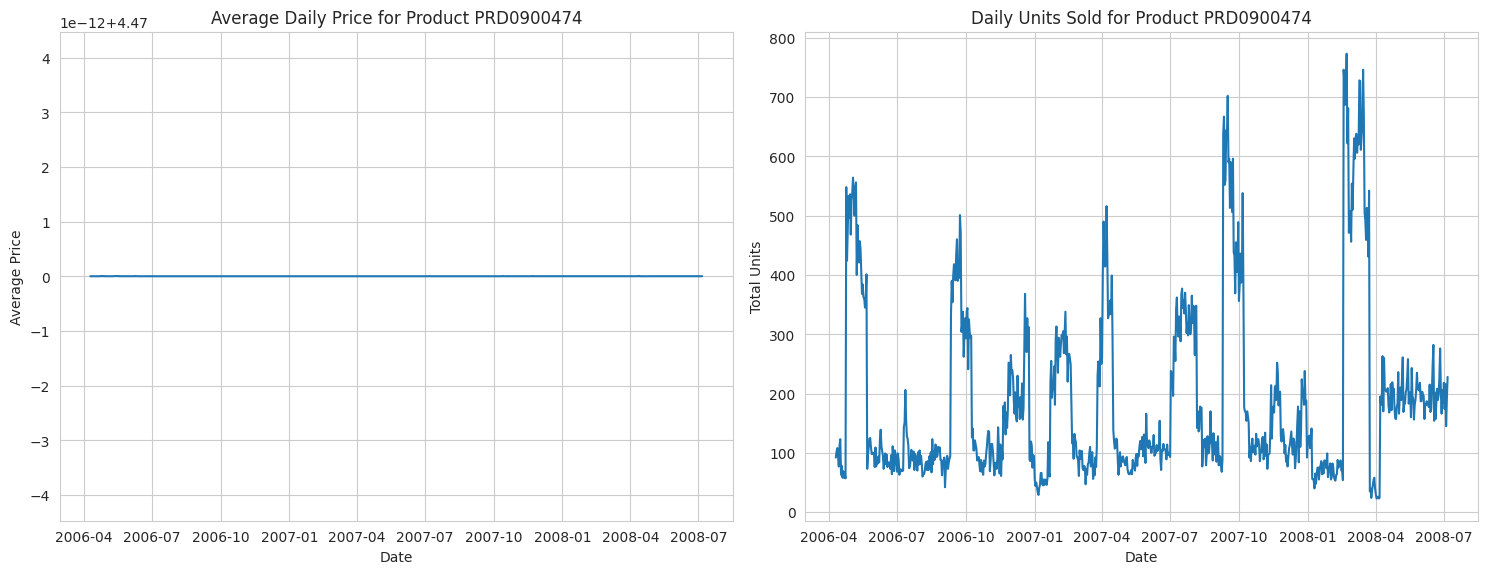

In [12]:
# 1. Get a list of unique product IDs
all_product_ids = product_daily.get_column("PROD_CODE").unique().to_list()

# 2. Select 3 random product IDs from the list
if len(all_product_ids) >= 3:
    random_products = random.sample(all_product_ids, 3)
else:
    # Handle the case where there are fewer than 3 products
    random_products = all_product_ids
    print(f"Warning: Only found {len(all_product_ids)} unique products. Plotting all of them.")


# 3. Convert the full Polars DataFrame to Pandas once for efficient plotting
product_daily_pd = product_daily.to_pandas()

# 4. Loop through the random products and create two plots for each
for product_id in random_products:
    # Filter the Pandas DataFrame for the current product ID
    product_df = product_daily_pd[product_daily_pd["PROD_CODE"] == product_id]
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot avg_price on the first subplot
    sns.lineplot(data=product_df, x="SHOP_DATE", y="avg_price", ax=ax1)
    ax1.set_title(f"Average Daily Price for Product {product_id}")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Average Price")
    
    # Plot total_units on the second subplot
    sns.lineplot(data=product_df, x="SHOP_DATE", y="total_units", ax=ax2)
    ax2.set_title(f"Daily Units Sold for Product {product_id}")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Total Units")
    
    plt.tight_layout() # Adjusts subplots to fit into figure area
    plt.show()

In [20]:
# Group by product code to find the min and max average price for each product
constant_price_products = (
    product_daily
    .group_by("PROD_CODE")
    .agg(
        pl.min("avg_price").alias("min_price"),
        pl.max("avg_price").alias("max_price")
    )
    # Filter for products where the min and max price are identical
    .filter(pl.col("min_price") == pl.col("max_price"))
    .select("PROD_CODE")
)

# Get the count of products with a constant price
num_constant_price_products = constant_price_products.shape[0]

print(f"Number of products with a constant price: {num_constant_price_products}")
print("Products with constant prices:")
print(constant_price_products)

Number of products with a constant price: 5
Products with constant prices:
shape: (5, 1)
┌────────────┐
│ PROD_CODE  │
│ ---        │
│ str        │
╞════════════╡
│ PRD0904945 │
│ PRD0902029 │
│ PRD0903788 │
│ PRD0900357 │
│ PRD0903627 │
└────────────┘


## Feature Engineering

In [ ]:
daily_agg_with_features_lazy = daily_agg_lazy.with_columns([
    # Time-based features
    pl.col("date").dt.weekday().alias("day_of_week"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.weekday().is_in([6, 7]).alias("is_weekend"),
    
    # Lag features
    pl.col("total_units").shift(1).over("product_id").alias("lag_1_units"),
    pl.col("total_units").shift(7).over("product_id").alias("lag_7_units"),
    pl.col("total_units").shift(30).over("product_id").alias("lag_30_units"),
    
    # Rolling mean features
    pl.col("total_units").rolling_mean(7).over("product_id").alias("rolling_mean_7_units"),
    pl.col("total_units").rolling_mean(30).over("product_id").alias("rolling_mean_30_units"),
    
    # Price change feature
    (pl.col("avg_price") / pl.col("avg_price").shift(1) - 1).over("product_id").alias("price_change_pct")
])

print("Schema with new features:")
print(daily_agg_with_features_lazy.schema)

print("Head with new features:")
daily_agg_with_features_lazy.head().collect()

## Demand distribution

In [29]:
# Function to model a normal distribution for demand given a given product
def model_demand_normal(product_code, num_simulations=1000):
    # Filter the DataFrame for the specified product code
    df_filtered = product_daily_pd[product_daily_pd['PROD_CODE'] == product_code]
    
    if df_filtered.empty:
        print(f"No data found for product code: {product_code}")
        return None
    
    # Calculate the mean and standard deviation of units sold
    mu = df_filtered['total_units'].mean()
    sigma = df_filtered['total_units'].std()
    
    print(f"Mean units sold for product {product_code}: {mu}")
    print(f"Standard deviation of units sold for product {product_code}: {sigma}")
    
    # Simulate demand using a normal distribution
    simulated_units = np.random.normal(mu, sigma, num_simulations)

    mu_est = np.mean(simulated_units)
    sigma_est = np.std(simulated_units, ddof=1)  # unbiased estimator

    print(f"Estimated mean: {mu_est:.2f}")
    print(f"Estimated std dev: {sigma_est:.2f}")

    # Create a range of x values
    x = np.linspace(min(simulated_units), max(simulated_units), 100)

    # Compute the PDF using the estimated parameters
    pdf_est = norm.pdf(x, mu_est, sigma_est)

    # Plot
    plt.figure(figsize=(8,5))
    plt.hist(simulated_units, bins=30, density=True, alpha=0.6, color='lightblue', label='Empirical data')
    plt.plot(x, pdf_est, 'r-', lw=2, label=f'Normal fit\nμ={mu_est:.1f}, σ={sigma_est:.1f}')
    plt.title('Modeling a Normal Distribution from Data')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return simulated_units

Mean units sold for product PRD0900324: 287.3260073260073
Standard deviation of units sold for product PRD0900324: 145.1312531154492
Estimated mean: 297.42
Estimated std dev: 142.06


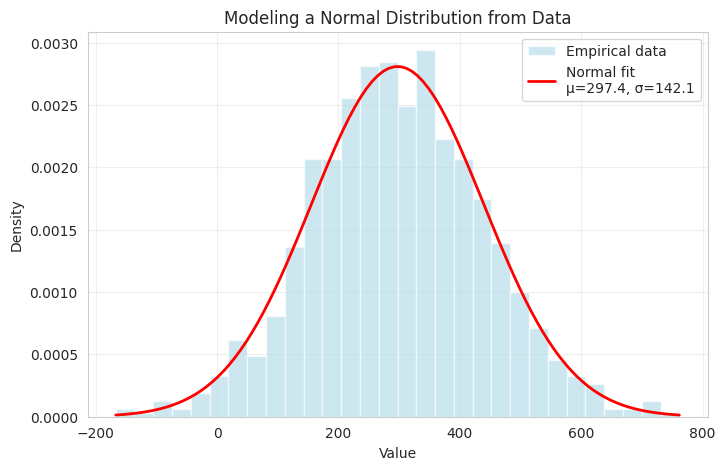

In [30]:
# Model demand for a specific product
simulated_demand = model_demand_normal('PRD0900324', num_simulations=1000)